In [50]:
import json
import logging
import urllib
from IPython.display import Image as I_note
from IPython.display import display
from IPython.core.display import HTML
from multiprocessing.dummy import Pool as ThreadPool

import numpy as np
import pytesseract  # need to install using pip
from PIL import Image  # need to install Pillow using pip

In [49]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions, InceptionV3

import numpy as np
import os

# If you want to use a GPU set its index here
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [44]:
model = InceptionV3(weights='imagenet')

In [94]:
with open('memes.json') as f:
    data = json.load(f)

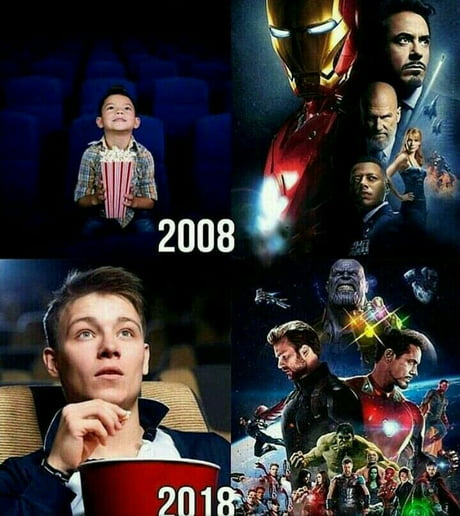

In [109]:
path = download(data[8], 'content')
display(I_note(path, width=200, height=200))

In [110]:
text,predictions,title = down_fix(data[8],'content')
print('Text: %s' %text)
print('Title: %s' % title)
print('Predictions: %s' % predictions)

Text: 
Title: Once a fan, always a fan.
Predictions: ['stage', 'comic_book', 'steel_drum', 'drum', 'cup']


In [87]:
def fix(meme, image_loc):

    # read in meme data and create image instance
    image = Image.open(image_loc)

    # get text from image and box coords
    text = pytesseract.image_to_string(image)
    box = pytesseract.image_to_boxes(image)

    # make something useful out of shitty return format for box
    spl = box.split('\n')
    coords = []
    lowercase = 'abcdefghijklmnopqrstuvwxyz'
    uppercase = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    numbers = '1234567890'
    symbols = "!@#$%&:;<>,.?`/\[]{}()^'" + '"'
    allowable_chars = lowercase + uppercase + numbers + symbols

    # create list of dictionaries with characters and their coordinates
    if len(box) > 1:
        for line in spl:
            chars = line.split(' ')
            char = chars[0]
            if char in allowable_chars:
                coord = {'char': char,
                         'x_start': chars[1],
                         'x_end': chars[3],
                         'y_start': chars[2],
                         'y_end': chars[4]}
                coords.append(coord)

        # create boxes over characters in image
        fixed_image = image.copy()

        # confirm image access
        # if fixed_image.pyaccess:
        color = (255, 255, 255)  # white boxes
        width, height = fixed_image.size
        for dic in coords:
            if int(dic['x_start']) - 2 > 1 and int(dic['x_end']) + 3 < width:
                x_list = np.arange(int(dic['x_start']) - 2, int(dic['x_end']) + 2)
            else:
                x_list = np.arange(int(dic['x_start']) + 1, int(dic['x_end']) - 1)

            if int(dic['y_start']) - 2 > 1 and int(dic['y_end']) + 3 < height:
                y_list = np.arange(int(dic['y_start']) - 2, int(dic['y_end']) + 2)
            else:
                y_list = np.arange(int(dic['y_start']) + 1, int(dic['y_end']) - 1)

            for x in x_list:
                for y in y_list:  # write over pixel with color
                    xy = (x, (height - y))
                    fixed_image.putpixel(xy, color)

        
        fixed_image.save(image_loc, 'PNG')

        # add new file location and text data to dictionary
        return text,image_loc
    else:

        logging.warning('No text found. Skipping')
        
        return None,image_loc
    
def download(meme, url_key='content'):
    image_name = meme[url_key].split('/')[-1]
    urllib.request.urlretrieve(meme[url_key], image_name)
    return image_name

def down_fix(meme, url_key='content', remove=True):
    url = meme[url_key]
    if '.jpg' not in url and not '.png' in url:
        return None, None
    path = download(meme, url_key)
    text,path = fix(meme, path)
    img = image.load_img(path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    
    if remove:
        os.remove(path)
    return text,[m[1] for m in decode_predictions(preds, top=5)[0]], meme['title']